# Projeto Inteligência Artifical (Afonso Fernandes - 2221437, Luís Oliveira - 2221441)

- Conjunto de validação train4

### T

- Modelo transfer learning

- Otimizador: 

- Com e sem Data Augmentation

## Erros: erros ligados à memória da gpu e cópida de tensors da cpu para a gpu

### Tentar resolver problemas relacionados com memória da gpu -> Dor de cabeça

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only allocate 2GB of memory on the first GPU
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)]
        )
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)


1 Physical GPUs, 1 Logical GPUs


### Utilização extensiva de **with tf.device('/device:GPU:0')** -> pois também aparenta ter "reparado" um problema

## Dados Base:

In [4]:
from keras.utils import image_dataset_from_directory
import tensorflow as tf


with tf.device('/device:GPU:0'):
    train_dir_1 = 'trainning/train1'
    train_dir_2 = 'trainning/train2'
    train_dir_3 = 'trainning/train3'
    validation_dir = 'train4' # Validation
    train_dir_5 = 'trainning/train5'
    test_dir = 'test'

    trainning = [train_dir_1, train_dir_2,train_dir_3,train_dir_5]

    train_dir = train_dir_2
    IMG_SIZE = 150  # InceptionResNetV2 requires 299x299 images

    # image_dataset_from_directory with labels="inferred" for 
    # getting the images in the subdirectories and translating the subdirectory as a class 
    # of type categorical
    #train_dataset = image_dataset_from_directory(train_dir,image_size=(IMG_SIZE, IMG_SIZE),batch_size=32, labels="inferred", label_mode="categorical")
    test_dataset = image_dataset_from_directory(test_dir,image_size=(IMG_SIZE, IMG_SIZE), labels="inferred",label_mode="categorical")
    validation_dataset = image_dataset_from_directory(validation_dir,image_size=(IMG_SIZE, IMG_SIZE), labels="inferred",label_mode="categorical")

    train_dataset = tf.data.Dataset

    for i in trainning:
        if i == trainning[0]:
            train_dataset = image_dataset_from_directory(i, image_size=(IMG_SIZE, IMG_SIZE), labels="inferred", label_mode="categorical")
            continue
        train_dataset = train_dataset.concatenate( image_dataset_from_directory(i, image_size=(IMG_SIZE, IMG_SIZE), labels="inferred", label_mode="categorical"))




Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.


In [3]:
import matplotlib.pyplot as plt

def graph(history):
    # Use the correct key names from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b-', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'b-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


### Conseguir os features e as labels para um treino sem a necessidade de estar sempre a processar as imagens com o modelo convolucional

In [ ]:
import tensorflow as tf
import numpy as np
from keras.applications.densenet import DenseNet121, preprocess_input
NUM_CLASSES = 10
# Define base model
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False
def get_features_and_labels(dataset):
    tf.keras.backend.clear_session()

    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = preprocess_input(images)
        features = base_model.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)
with tf.device('/gpu:0'):
    train_features, train_labels = get_features_and_labels(train_dataset)
    val_features, val_labels = get_features_and_labels(validation_dataset)
    test_features, test_labels = get_features_and_labels(test_dataset)

    # Convert the features and labels into tf.data.Dataset
    train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
    val_dataset = tf.data.Dataset.from_tensor_slices((val_features, val_labels))
    test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels))


In [ ]:
np.save('train_features.npy', train_features)
np.save('val_features.npy', val_features)
np.save('test_features.npy', test_features)
np.save('train_labels.npy', train_labels)
np.save('val_labels.npy', val_labels)
np.save('test_labels.npy', test_labels)

### Classe para definir as batchs, pois o tensorflow estava a dar load da informção toda, o que piorava o problema de espaço na gpu

In [18]:
from keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

In [19]:

from numpy import load
import numpy as np
train_features = load('train_features.npy')
val_features = load('val_features.npy')
test_features = load('test_features.npy')
train_labels = load('train_labels.npy')
val_labels = load('val_labels.npy')
test_labels = load('test_labels.npy')

train_gen = DataGenerator(train_features, train_labels, 32)
val_gen = DataGenerator(val_features, val_labels, 32)
test_gen = DataGenerator(test_features, test_labels, 32)


### Optimização da procura de hyperparâmetros através do optuna, reutilização do Modus Operandi do modelo S

In [8]:
import optuna
import keras
from keras import layers
import tensorflow as tf
import numpy as np

with tf.device('/device:GPU:0'):

    def create_model(trial):
        keras.backend.clear_session()
        # Define the regularization and dropout values
        reg = keras.regularizers.l2(0.005)
        dropFinal = 0.5

        # Add custom top layers
        #inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
        #x = base_model(inputs, training=False)
        inputs = keras.Input(shape=(4, 4, 1024))
        x = layers.Flatten()(inputs)
        x = layers.Dense(trial.suggest_int('dense_units', 256, 512, step=256), activation='relu', kernel_regularizer=reg)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropFinal)(x)
        outputs = layers.Dense(10, activation='softmax')(x)
        
        model = keras.Model(inputs, outputs)
        
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=trial.suggest_float('learning_rate_IN', 1e-3, 1e-2,log=True),
            decay_steps=1000,
            decay_rate=0.6,
            staircase=True
        )

        optimizer_options = ['Adam', 'RMSprop']
        optimizer_selected = trial.suggest_categorical('optimizer', optimizer_options)
        if optimizer_selected == 'Adam':
            optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
        else:
            optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)

        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        
        return model

    def objective(trial):
        model = create_model(trial)
        
        # ModelCheckPoint - por cada trial
        callbacks = [
            keras.callbacks.ModelCheckpoint(
                filepath=f'models_T/model_best_{trial.number}.h5',
                save_best_only=True,
                monitor='val_loss',
                mode='min',
                verbose=0
            ),# EarlyStopping -> beneficia os modelos e o tempo que o estudo demora
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                min_delta=0,
                patience=4,
                verbose=0,
                mode='min',
                restore_best_weights=True,
            )
        ]
        # Batch Size pequeno por questões de memória
        batch_size = trial.suggest_int('batch_size', 8, 16, step=8)
        
        history = model.fit(
            train_gen,
            epochs=50,
            validation_data=val_gen,
            callbacks=callbacks,
            verbose=0
        )
        
        val_loss = history.history['val_loss'][-1]
        #graph(history)
        return val_loss




In [9]:
with tf.device('/device:GPU:0'):
    # Criar estudo 
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=5)

    print("Best trial:")
    trial = study.best_trial

    print(f"Value: {trial.value}")
    print("Params:")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

[I 2024-06-21 14:43:13,981] A new study created in memory with name: no-name-539c8147-8120-45d0-937b-708970b798e4
[I 2024-06-21 14:47:57,126] Trial 0 finished with value: 0.3780383765697479 and parameters: {'dense_units': 512, 'learning_rate_IN': 0.005635956693486822, 'optimizer': 'RMSprop', 'batch_size': 16}. Best is trial 0 with value: 0.3780383765697479.
[I 2024-06-21 14:50:26,674] Trial 1 finished with value: 0.40196800231933594 and parameters: {'dense_units': 256, 'learning_rate_IN': 0.003940804197661017, 'optimizer': 'Adam', 'batch_size': 8}. Best is trial 0 with value: 0.3780383765697479.
[I 2024-06-21 14:53:37,403] Trial 2 finished with value: 0.40288031101226807 and parameters: {'dense_units': 512, 'learning_rate_IN': 0.002841172025338205, 'optimizer': 'Adam', 'batch_size': 8}. Best is trial 0 with value: 0.3780383765697479.
[I 2024-06-21 14:56:39,195] Trial 3 finished with value: 0.37962549924850464 and parameters: {'dense_units': 256, 'learning_rate_IN': 0.002753796676664349

Best trial:
Value: 0.3780383765697479
Params:
    dense_units: 512
    learning_rate_IN: 0.005635956693486822
    optimizer: RMSprop
    batch_size: 16


### Continuar o treino

In [10]:
import keras
# Load do novo melhor modelo
keras.backend.clear_session()

model = keras.models.load_model("models_T\model_best_0.h5")
#model = create_model(study.best_trial)

Epoch 1/100
624/624 [==============================] - 12s 19ms/step - loss: 0.0997 - accuracy: 0.9944 - val_loss: 0.3771 - val_accuracy: 0.9010
Epoch 2/100
624/624 [==============================] - 11s 17ms/step - loss: 0.0949 - accuracy: 0.9952 - val_loss: 0.3803 - val_accuracy: 0.9008
Epoch 3/100
624/624 [==============================] - 11s 17ms/step - loss: 0.0898 - accuracy: 0.9963 - val_loss: 0.3774 - val_accuracy: 0.9012
Epoch 4/100
624/624 [==============================] - 11s 17ms/step - loss: 0.0888 - accuracy: 0.9960 - val_loss: 0.3790 - val_accuracy: 0.9008
Epoch 5/100
624/624 [==============================] - 11s 17ms/step - loss: 0.0866 - accuracy: 0.9967 - val_loss: 0.3776 - val_accuracy: 0.8994
Epoch 5: early stopping


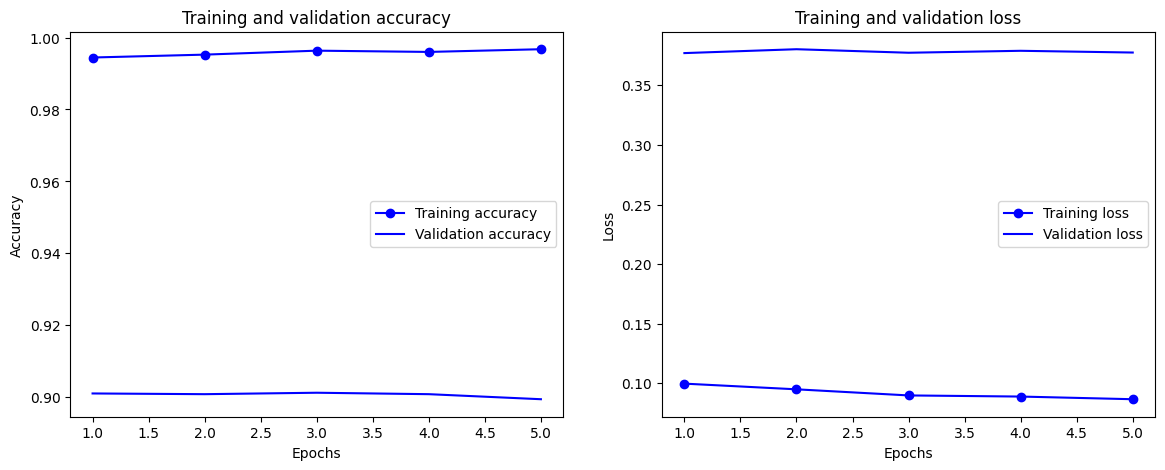

In [11]:

with tf.device('/device:GPU:0'):

    callbacks = [
            keras.callbacks.ModelCheckpoint(
                filepath='models_T/model_best_First.h5',
                save_best_only=True,
                monitor='val_loss',
                mode='min',
                verbose=0
            ),
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                min_delta=0,
                patience=4,
                verbose=1,
                mode='min',
                restore_best_weights=True,
            )
        ]
    
    history = model.fit(
            train_gen,
            batch_size=16,
            epochs=100,
            validation_data=val_gen,
            callbacks=callbacks,
            verbose=1
        )
    
    graph(history)

### Aqui vemos overfitting a ocurrer, com uma grande diferença, quase 10%

In [13]:

val_loss, val_acc = model.evaluate(test_gen) #test_gen
print('Test_acc:', val_acc,'\nTest_loss:', val_loss)

#keras.models.save_model(model,'models_T/model_best_First.h5')

156/156 [==============================] - 1s 5ms/step - loss: 0.4282 - accuracy: 0.8890
Test_acc: 0.8890224099159241 
Test_loss: 0.42822524905204773


## Modelo com Data Augmentation

In [4]:
from keras.applications.densenet import DenseNet121

#model = create_model(study.best_trial)
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False


In [ ]:
import keras
keras.backend.clear_session()
model = keras.models.load_model("models_T\model_best_DA.h5")

In [5]:
import optuna
import keras
from keras import layers
import tensorflow as tf
import numpy as np
from keras.applications.densenet import preprocess_input
with tf.device('/device:GPU:0'):

    def create_model1(trial):
        keras.backend.clear_session()
        # Define the regularization and dropout values
        reg = keras.regularizers.l2(0.005)
        dropFinal = 0.5
        data_augmentation = keras.Sequential(
            [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.2),
            ]
            )

        # Add custom top layers
        inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
        x = data_augmentation(inputs)
        x = preprocess_input(x)
        x = base_model(x)
        x = layers.Flatten()(x)
        x = layers.Dense(trial.suggest_int('dense_units', 256, 512, step=256), activation='relu', kernel_regularizer=reg)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropFinal)(x)
        outputs = layers.Dense(10, activation='softmax')(x)
        
        model = keras.Model(inputs, outputs)
        
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=trial.suggest_float('learning_rate_IN', 1e-3, 1e-2,log=True),
            decay_steps=1000,
            decay_rate=0.6,
            staircase=True
        )

        optimizer_options = ['Adam', 'RMSprop']
        optimizer_selected = trial.suggest_categorical('optimizer', optimizer_options)
        if optimizer_selected == 'Adam':
            optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
        else:
            optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)

        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    def objective1(trial):
        model = create_model1(trial)
        
        callbacks = [
            keras.callbacks.ModelCheckpoint(
                filepath=f'models_T/model_best_DA_{trial.number}.h5',
                save_best_only=True,
                monitor='val_loss',
                mode='min',
                verbose=0
            ),
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                min_delta=0,
                patience=4,
                verbose=0,
                mode='min',
                restore_best_weights=True,
            )
        ]
        batch_size = trial.suggest_int('batch_size', 8, 16, step=8)
        
        history = model.fit(
            train_dataset,
            batch_size=batch_size,
            epochs=20,
            validation_data=validation_dataset,
            callbacks=callbacks,
            verbose=0
        )
        
        val_loss = history.history['val_loss'][-1]
        graph(history)
        return val_loss




c:\Users\HP\.conda\envs\tensorflow_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[I 2024-06-21 16:00:05,906] A new study created in memory with name: no-name-710ac114-88a7-4b12-a922-7f2055f1de80


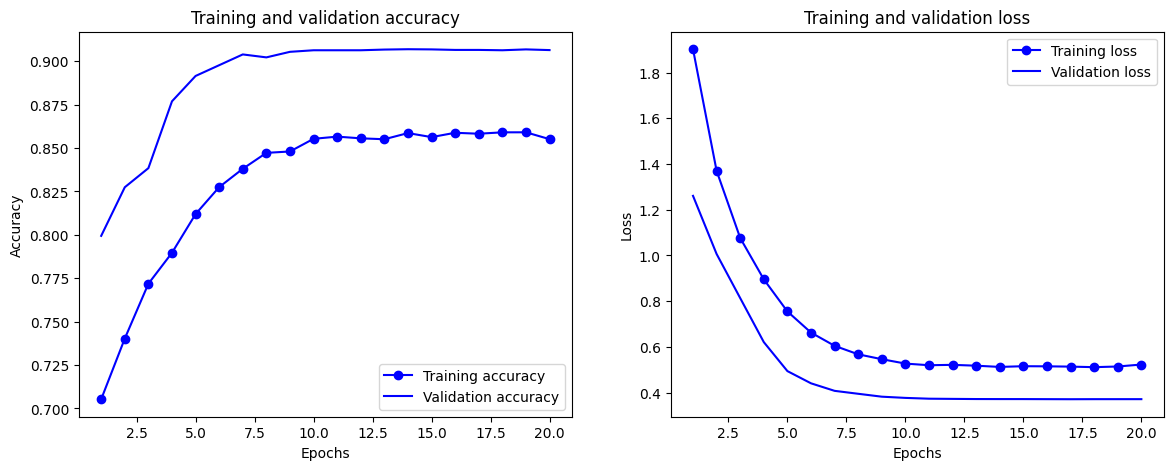

[I 2024-06-21 19:09:35,762] Trial 0 finished with value: 0.3711468577384949 and parameters: {'dense_units': 256, 'learning_rate_IN': 0.0022450991228308436, 'optimizer': 'RMSprop', 'batch_size': 8}. Best is trial 0 with value: 0.3711468577384949.


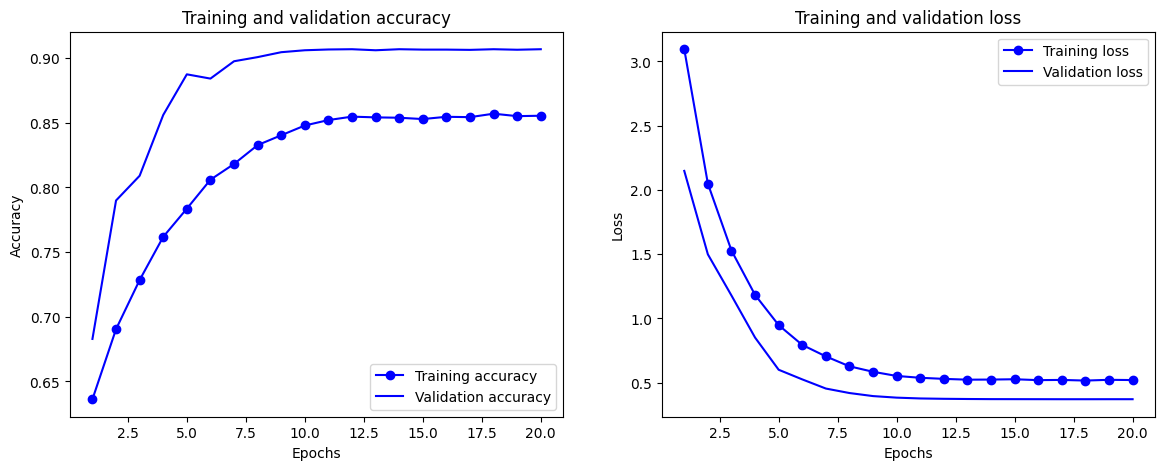

[I 2024-06-21 22:19:22,902] Trial 1 finished with value: 0.37190961837768555 and parameters: {'dense_units': 256, 'learning_rate_IN': 0.005973644332066574, 'optimizer': 'RMSprop', 'batch_size': 16}. Best is trial 0 with value: 0.3711468577384949.


[W 2024-06-21 22:19:44,275] Trial 2 failed with parameters: {'dense_units': 256, 'learning_rate_IN': 0.004038801351193084, 'optimizer': 'RMSprop', 'batch_size': 16} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\HP\.conda\envs\tensorflow_gpu\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\HP\AppData\Local\Temp\ipykernel_17016\728027330.py", line 74, in objective1
    history = model.fit(
  File "c:\Users\HP\.conda\envs\tensorflow_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "c:\Users\HP\.conda\envs\tensorflow_gpu\lib\site-packages\keras\engine\training.py", line 1564, in fit
    tmp_logs = self.train_function(iterator)
  File "c:\Users\HP\.conda\envs\tensorflow_gpu\lib\site-packages\tensorflow\python\util\traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
 

KeyboardInterrupt: 

In [6]:
with tf.device('/device:GPU:0'):

    study = optuna.create_study(direction='minimize')
    study.optimize(objective1, n_trials=3)

    print("Best trial:")
    trial = study.best_trial

    print(f"Value: {trial.value}")
    print("Params:")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

### Aqui vemos underfitting a ocurrer, com uma grande diferença, quase 5%

In [4]:
import keras
# Load do novo melhor modelo
keras.backend.clear_session()

model = keras.models.load_model("models_T\model_best_DA_0.h5")
#model = create_model(study.best_trial)

Restoring model weights from the end of the best epoch: 7.
Epoch 10: early stopping


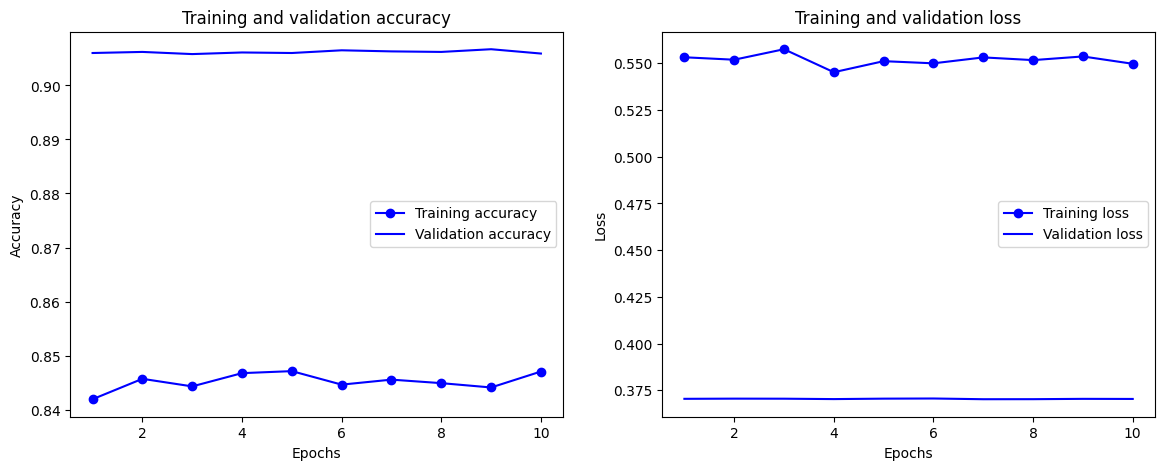

In [5]:

with tf.device('/device:GPU:0'):

    callbacks = [
            keras.callbacks.ModelCheckpoint(
                filepath='models_T/model_best_DAFirst_0.h5',
                save_best_only=True,
                monitor='val_loss',
                mode='min',
                verbose=0
            ),
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                min_delta=0,
                patience=3,
                verbose=1,
                mode='min',
                restore_best_weights=True,
            )
        ]
    
    history = model.fit(
            train_dataset,
            batch_size=16,
            epochs=20,
            validation_data=validation_dataset,
            callbacks=callbacks,
            verbose=0
        )
    
    graph(history)

### Aqui vemos underfitting a ocurrer, com uma grande diferença, quase 6%

In [19]:
base_model = model.get_layer("densenet121")
base_model.trainable = True
print(model.layers)
#agora, aquecimento
for layer in base_model.layers[:-6]:
    layer.trainable = False
    
for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)

[<keras.engine.input_layer.InputLayer object at 0x00000240253A10D0>, <keras.engine.sequential.Sequential object at 0x00000240253A1220>, <keras.layers.core.tf_op_layer.TFOpLambda object at 0x000002402BCD9F40>, <keras.layers.core.tf_op_layer.TFOpLambda object at 0x0000024025571EB0>, <keras.layers.core.tf_op_layer.TFOpLambda object at 0x00000240255D6400>, <keras.engine.functional.Functional object at 0x0000024025726A60>, <keras.layers.reshaping.flatten.Flatten object at 0x0000024025726940>, <keras.layers.core.dense.Dense object at 0x000002402582DD30>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000024025733190>, <keras.layers.regularization.dropout.Dropout object at 0x0000024025A308B0>, <keras.layers.core.dense.Dense object at 0x0000024025A49DC0>]
0 input_1 False
1 zero_padding2d False
2 conv1/conv False
3 conv1/bn False
4 conv1/relu False
5 zero_padding2d_1 False
6 pool1 False
7 conv2_block1_0_bn False
8 conv2_block1_0_relu False
9 conv2_block1_1_conv 

Restoring model weights from the end of the best epoch: 6.
Epoch 9: early stopping


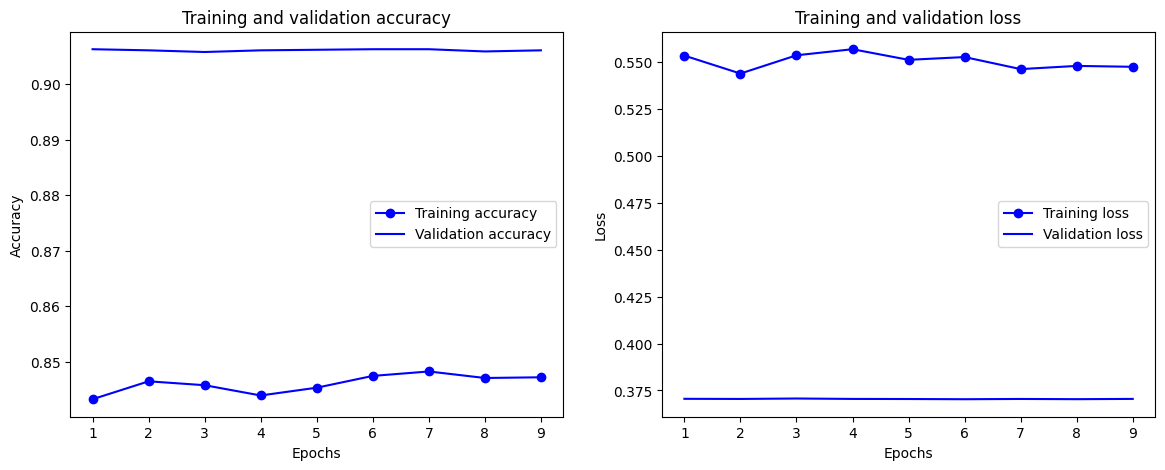

In [20]:
with tf.device('/device:GPU:0'):

    callbacks = [
            keras.callbacks.ModelCheckpoint(
                filepath='models_T/model_best_DAFirst_0_FT.h5',
                save_best_only=True,
                monitor='val_loss',
                mode='min',
                verbose=0
            ),
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                min_delta=0,
                patience=3,
                verbose=1,
                mode='min',
                restore_best_weights=True,
            )
        ]
    
    history = model.fit(
            train_dataset,
            batch_size=16,
            epochs=20,
            validation_data=validation_dataset,
            callbacks=callbacks,
            verbose=0
        )
    
    graph(history)

### No fim do fine tunning vemos que o underfitting pode ser causado pelas imagens do treino

In [27]:
val_loss, val_acc = model.evaluate(test_gen) #test_gen
print('Test_acc:', val_acc,'\nTest_loss:', val_loss)

#keras.models.save_model(model,'models_T/model_best_DAFirst.h5')

156/156 [==============================] - 1s 6ms/step - loss: 0.4282 - accuracy: 0.8890
Test_acc: 0.8890224099159241 
Test_loss: 0.42822524905204773
